In [1]:
### Import statements
# For generating dummy training data
from pyDOE2 import *
import numpy as np
# For Abaqus FEA evaluation
from subprocess import Popen, PIPE
# For Neural Network
import csv
from keras.models import load_model
# For gaussian process regressors
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from math import sin, cos, pi, radians
# For Optimization
import copy
from scipy.stats import norm
import warnings
# For plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Using TensorFlow backend.


# Bayesian Optimization
- This notebook details the implementation of a modified version of the multifidelity constrained Bayesian Optimization algorithm from: Ghoreishi, Seyede Fatemeh, and Douglas Allaire. "Multi-information source constrained Bayesian optimization." Structural and Multidisciplinary Optimization 59, no. 3 (2019): 977-991.
- The algorithm is first tested on a benchmark problem taken from the above mentioned paper to make sure the algorithm is working satisfactorily
- After validation using the test problem, the algorithm is used on the composite plate problem

## Model Function Definitions for Composite Plate problem
- The model functions for the composite plate problem are defined below
- The design parameters are fibre radius (r_f), fibre_angle (theta_f) and matrix Young's Modulus (E_m)
- The objective to maximize is the buckling load (P_cr)
- Three models are available: a high fidelity FEA model (using Abaqus Python Scipting), a low fidelity analytical model and a low fidelity Neural Network (trained using FEA model evaluations)
- The constraint is that the volume fraction (v_f) must be less than 0.75.
- Two simplified versions of this constraint are available, termed g_1(x) and g_2(x) respectively

In [2]:
### Define the model functions for Composite Plate problem
## Analytical Model (Low Fidelity Model 1)
def analytical(x,n_eigen):
    # Here l,w,t are the length, width and thickness of the plate and E_f is the fibre Young's Modulus
    # These are defined as global variables
    r_f = x[0] # in mm
    theta_f = x[1] # in degrees
    E_m = x[2] # in GPa
    P_cr = []
    poisson_ratio = 0.3
    v_f = volume_fraction(l,w,t,x)
    ## Rule of Mixtures
    E_effective = (E_f*v_f + (1-v_f)*E_m)*1e3 # Converting to N/mm^2
    D = E_effective*t**3/(12*(1-poisson_ratio**2)) # Flexural Rigidity
    for i in range(n_eigen):
        m = i+1
        n = 1
        P_cr.append(D*(pi*l/m)**2*((m/l)**2+(n/w)**2)**2)
    return P_cr
    
# Volume Fraction
def volume_fraction(length,width,thickness,x_design):
    r_f = x_design[0]
    theta_f = x_design[1]
    v_total = length*width*thickness
    l_fibre_shortest = length/(6*cos(radians(theta_f)))
    l_fibre_med = 2*l_fibre_shortest
    l_fibre_longest = 3*l_fibre_shortest
    vol_fibres = pi*(r_f**2)*(2*l_fibre_shortest + 2*l_fibre_med + l_fibre_longest)
    vol_total = length*width*thickness
    vol_frac = vol_fibres/vol_total
    return vol_frac
    
## Neural Network (Lower Fidelity Model 2)
network = load_model('Buckling_Neural_Net_norm.h5')
# Load the normalization constants from the csv file
with open('normalization_constants.csv',newline='')as csvfile:
    data = [row for row in csv.reader(csvfile)]
    data_row = data[1]
    data_mean_float = [float(data_row[0]), float(data_row[1]), float(data_row[2])]
    data_var_float = [float(data_row[3]), float(data_row[4]), float(data_row[5])]

def neural_net(x):
    # The output of the neural network is scaled using the normalization constants to give the actual prediction
    P_cr_norm = network.predict(x.reshape(1,-1))
    P_cr = P_cr_norm*np.sqrt(data_var_float) + data_mean_float
    return P_cr

## Abaqus FEA model (Ground Truth)
def abaqus_fea(x, job_num):
    r_f = x[0] # in mm
    theta_f = x[1] # in degrees
    E_m = x[2]*1000 # in N/mm^2
    
    # Running the abaqus job for the given parameters as a subprocess through the command line
    sys_command = ['abaqus','cae','noGUI=abaqus_fea_macro.py','--',str(r_f),str(theta_f),str(E_m),str(job_num)]
    process = Popen(sys_command, stdout=PIPE, stderr=PIPE, cwd=r'H:/Desktop/MSEN 655 - Material Design Studio/python code/final bayesian optimization run',shell=True)
    process.wait()
    stdout, stderr = process.communicate()
    output_string = stdout.decode("utf-8")
    
    ## Reading the outputs string to extract the eigenvalue information
    # The output string has the form "Eigenvalue One: value Endone, Eigenvalue Two: value Endtwo, Eigenvalue Three: value Endthree"
    # More information on the extraction specifics is given in Neural_net_training_kfold.py
    # If the abaqus evaluation fails because of meshing issues and "Error" is thrown, the design is evaluated using the analytical model instead
    if (output_string.find('Error') == -1):
        Eigen_1_pos_start = output_string.find('One') + 6
        Eigen_1_pos_end = output_string.find('Endone') - 1
        Eigen_2_pos_start = output_string.find('Two') + 6
        Eigen_2_pos_end= output_string.find('Endtwo') - 1
        Eigen_3_pos_start = output_string.find('Three') + 8
        Eigen_3_pos_end = output_string.find('Endthree') - 1
    
        buckling_load_e1 = output_string[Eigen_1_pos_start:Eigen_1_pos_end-1]
        buckling_load_e2 = output_string[Eigen_2_pos_start:Eigen_2_pos_end-1]
        buckling_load_e3 = output_string[Eigen_3_pos_start:Eigen_3_pos_end-1]
        
        buckling_eigen_1 = float(buckling_load_e1[2:])
        if (buckling_load_e2.find('E+') != -1):
            buckling_eigen_2 = float(buckling_load_e2[1:])
        else:
            buckling_eigen_2 = float(buckling_load_e2[2:])
            
        if (buckling_load_e3.find('E+') != -1):
            buckling_eigen_3 = float(buckling_load_e3[1:-1])
        else:
            buckling_eigen_3 = float(buckling_load_e3[2:-2])
    
        P_cr = [buckling_eigen_1, buckling_eigen_2, buckling_eigen_3]
    else:
        P_cr = analytical(x, 3)
    
    process.kill()
    return P_cr

## High fidelity Constraint Model
def constraint_hf(x, vf_limit):
    vf_x = volume_fraction(l,w,t,x)
    constraint = vf_x - vf_limit
    return constraint

## First Lower Fidelity Constraint Model
def constraint_lf1(x, vf_limit):
    r_f = x[0]
    theta_f = x[1]
    const_g1 = r_f**2/(1000*cos(radians(theta_f))) - vf_limit
    return const_g1

## Second Lower Fidelity Constraint Model
def constraint_lf2(x, vf_limit):
    r_f = x[0]
    theta_f = x[1]
    const_g2 = (r_f**2/(1000*sin(radians(theta_f))) + 0.1) - vf_limit
    return const_g2

## Model Function Definitions for Test problem
- The model functions for the test problem are defined below
- The design space is one-dimensional
- The objective to be maximized
- Three objective models are available: a high fidelity model and two low fidelity models 
- Three constraint models are available: a high fidelity model and two low fidelity models

In [3]:
### Define the model functions for Test problem
## High fidelity objective model
def gt_obj(x):
    y_gt = -(1.4 - 3*x)*(sin(18*x))
    return y_gt

## Low fidelity objective model 1
def low_fid_obj1(x):
    y_f1 = -(1.6 - 3*x)*(sin(18*x))
    return y_f1

## Low fidelity objective model 2
def low_fid_obj2(x):
    y_f2 = -(1.8 - 3*x)*sin(18*x + 0.1)
    return y_f2

## High fidelity constraint model
def constraint_hf_test(x):
    y_c_gt = x**2 - 1.2
    return y_c_gt

## Low fidelity constraint model 1
def constraint_lf1_test(x):
    y_c_lf1 = (x - 0.001)**2 - 1.2
    return y_c_lf1

## Low fidelity constraint model 2
def constraint_lf2_test(x):
    y_c_lf2 = (x + 0.02)**2 - 1.2
    return y_c_lf2

## Utility Functions
- The functions defined below are represent operations performed frequently in the optimization algorithm
- The Utility functions are defined in a generalised manner so as to apply to both the test problem and the composite plate problem

In [4]:
### Some useful functions for the algorithm
## GPR training given design set and response
def gp_train(x,y,n_x,x_max,rand_state):
    x_dim = len(x_max)
    len_scale = []
    for ia in range(x_dim):
        len_scale.append(x_max[ia]*2/n_x)
    kernel = Matern(length_scale=len_scale, nu=2.5)
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=rand_state).fit(x,y)
    return gpr

## Computing fidelity variance (model discrepancy)
def fidelity_variance(x,gp_gt,gp1,gp2):
    # The fidelity variance is computed over a dataset different from the GP training datasets
    y_gt = gp_gt.predict(x)
    y_lf1 = gp1.predict(x)
    y_lf2 = gp2.predict(x)
    fid_var1 = np.mean(np.subtract(y_gt, y_lf1))**2
    fid_var2 = np.mean(np.subtract(y_gt, y_lf2))**2
    fid_var_vec = [fid_var1, fid_var2]
    return fid_var_vec

## Winkler Fusion
def Winkler_fusion(x, gp_1, gp_2, sigma_f1, sigma_f2, x_max, get_gp=False):
    n_des = len(x)
    
    gp1_means = np.zeros(n_des)
    gp1_stds = np.zeros(n_des)
    gp2_means = np.zeros(n_des)
    gp2_stds = np.zeros(n_des)
    gp_means = np.zeros([n_des,2])
    gp_vars = np.zeros([n_des,2])
    
    # Mean and std predictions at the given designs using the two GPs
    [gp1_means, gp1_stds] = gp_1.predict(x, return_std=True)
    [gp2_means, gp2_stds] = gp_2.predict(x, return_std=True)
    gp_means = np.column_stack((gp1_means, gp2_means))
    
    # Appending the model discrepancy values to the GP variances
    var_1 = gp1_stds**2 + sigma_f1
    var_2 = gp2_stds**2 + sigma_f2
    gp_vars = np.column_stack((var_1, var_2))
    
    # The fusion process
    rho_tilde = np.zeros([n_des,2,2])
    rho = np.zeros([n_des,2,2])
    covar = np.zeros([n_des,2,2])
    mean_winkler = np.zeros(n_des)
    var_winkler = np.zeros(n_des)
    
    for i in range(n_des):
        # Compute rho_tilde matrix for current design sample
        rho_tilde_x = np.zeros([2,2])
        mean_vec = gp_means[i,:]
        var_vec = gp_vars[i,:]
        for j1 in range(2):
            for k1 in range(2):
                mean_j = mean_vec[j1]
                mean_k = mean_vec[k1]
                var_j = var_vec[j1]
                var_k = var_vec[k1]
                rho_tilde_x[j1,k1] = np.sqrt(var_j)/(np.sqrt((mean_j - mean_k)**2 + var_j))
                
        # Compute correlation matrix for current design sample
        rho_x = np.zeros([2,2])
        for j2 in range(2):
            for k2 in range(2):
                var_j = var_vec[j2]
                var_k = var_vec[k2]
                rho_x[j2,k2] = (var_k/(var_j + var_k))*rho_tilde_x[j2,k2] + (var_j/(var_j + var_k))*rho_tilde_x[k2,j2]
                
        # Compute covariance matrix for current design sample
        #rho_x = rho[i,:,:]
        covar_x = np.zeros([2,2])                                             
        for j3 in range(2):
            for k3 in range(2):
                std_j = np.sqrt(var_vec[j3])
                std_k = np.sqrt(var_vec[k3])
                covar_x[j3,k3] = rho_x[j3,k3]*std_j*std_k
                
        # Compute Winkler Means and Variances
        e_vec = np.ones(2)
        mean_winkler[i] = (np.linalg.multi_dot([np.transpose(e_vec), np.linalg.inv(covar_x), mean_vec]))/(np.linalg.multi_dot([np.transpose(e_vec), np.linalg.inv(covar_x), e_vec]))
        var_winkler[i] = 1/(np.linalg.multi_dot([np.transpose(e_vec), np.linalg.inv(covar_x), e_vec]))
        rho_tilde[i,:,:] = rho_tilde_x
        rho[i,:,:] = rho_x
        covar[i,:,:] = covar_x
        
    # Train the fused GPR (if required)
    if (get_gp):
        gp_fused = gp_train(x,mean_winkler,n_des,x_max,n_des)
    else:
        gp_fused = None
    
    return mean_winkler, var_winkler, gp_fused

## Extracting feasible design points using the fused constraint GP
def filter_designs(x,gp_constraint_fused):
    n_des = len(x)
    const_mean = np.zeros(n_des)
    const_std = np.zeros(n_des)
    x_feas = []
    [const_mean, const_std] = gp_constraint_fused.predict(x, return_std=True)
    for i in range(n_des):
        if (const_mean[i] + 3*const_std[i] <= 0):
            x_feas.append(x[i,:])
    
    return np.array(x_feas)

## Expected Improvement computation
def exp_improv(fused_means, fused_vars, y_best_current):
    n_des = len(fused_means)
    EI = np.zeros(n_des)
    for i in range(n_des):
        mean_i = fused_means[i]
        var_i = fused_vars[i]
        if (var_i == 0):
            EI[i] = 0
        else:
            pdf_val = norm.pdf(mean_i, y_best_current, var_i)
            cdf_val = norm.pdf(mean_i, y_best_current, var_i)
            EI[i] = (mean_i - y_best_current)*cdf_val + var_i*pdf_val
    ei = np.amax(EI)
    return ei

## Information Gain computation
def info_gain(fused_means_prior, fused_vars_prior, fused_means_post, fused_vars_post, x_dim):
    n_des = len(fused_means_prior)
    kl_d = np.zeros(n_des)
    for i in range(n_des):
        kl_d[i] = ((fused_vars_prior[i]/fused_vars_post[i]) + ((fused_means_post[i] - fused_means_prior[i])**2/fused_vars_post[i]) - x_dim + np.log(fused_vars_post[i]/fused_vars_prior[i]))/2
    ig = np.sum(kl_d)/n_des
    return ig

## The Optimization Algorithm
- The cells below show the implementation of the multifidelity source constrained Bayesian Optimization algorithm
- The algorithm is implemented in function form for easy test runs using a mathematical benchmark problem taken from: Ghoreishi, Seyede Fatemeh, and Douglas Allaire. "Multi-information source constrained Bayesian optimization." Structural and Multidisciplinary Optimization 59, no. 3 (2019): 977-991.
- The Optimization function (called MFCBO for Multi Fidelity Constrained Bayesian Optimization) is defined in a generalised manner for easy deployment for the test problem and the composite plate problem. 
- The function is defined to accomodate different maximization problems with two low fidelity objective and constraint models. 
- Future improvements include further generalization of the function to incorporate different number of objective and constraint low fidelity models. 

In [12]:
def MFCBO(n_xvar, x_range, n_gt, n_f, n_const_gt, n_const, n_alt, n_test, cost_f, cost_c, max_cost, vf_limit, problem):
    n_fmod = len(n_f) # Number of lower fidelity objective models
    n_cmod = len(n_const) # Number of lower fidelity constraint models
    xmax = []
    for i in range(n_xvar):
        xmax.append(x_range[i][1])
        
    # Generated design samples for objectives and constraints
    x_f = {}
    y_f = {}
    x_c = {}
    y_c = {}
    gps_c = {}
    gps_f = {}
    # Costs of evaluation
    cost_f_gt = cost_f[0]
    cost_f_lf1 = cost_f[1]
    cost_f_lf2 = cost_f[2]
    cost_c_gt = cost_c[0]
    cost_c_lf1 = cost_c[1]
    cost_c_lf2 = cost_c[2]
    
    ## Projecting the designs from Latin Hypercube Sampling to the appropriate design space
    def sample_project(x, x_range, n_xvar):
        # x = [a_val, b_val, c_val]
        n_samp = len(x)
        
        x_projected = np.zeros([n_samp, n_xvar])
        for i in range(n_xvar):
            x_i_lower = x_range[i][0]
            x_i_upper = x_range[i][1]
            #x_i_projected = x[:,i]*(x_i_upper - x_i_lower) + np.ones(n_samp)*x_i_lower
            for j in range(n_samp):
                x_projected[j,i] = x[j,i]*(x_i_upper - x_i_lower) + x_i_lower
    
        return x_projected
    
    ## Define a job number (as a requirement for the abaqus fea function and to keep a track of the number of ground truth evaluations)
    job_num_gtup = 0 # Number of abaqus evaluations for updating the ground truth GP

    ######################### STEP 1 - Initialization #########################
    ## Generate design samples for constraints
    x_const = lhs(n_xvar, samples=n_const_gt, criterion='maximin')
    x_const_proj = sample_project(x_const, x_range, n_xvar)
    for i2 in range(n_cmod):
        x_ci = lhs(n_xvar, samples=n_const[i2], criterion='maximin')
        x_ci_proj = sample_project(x_ci, x_range, n_xvar)
        x_c[str(i2)] = x_ci_proj

    ## Generate design samples for the ground truth and lower fidelity model GPs
    x_gt = lhs(n_xvar, samples=n_gt, criterion='maximin')
    x_gt_proj = sample_project(x_gt, x_range, n_xvar)
    for i3 in range(n_fmod):
        x_fi = lhs(n_xvar, samples=n_f[i3], criterion='maximin')
        x_fi_proj = sample_project(x_fi, x_range, n_xvar)
        x_f[str(i3)] = x_fi_proj
    
    def init_iter(x_c_gt, y_c_gt_i, x_constraints, y_constraints_i, is_query_const, x_f_gt, y_f_gt_i, x_objectives, y_objectives_i, is_query_obj, n_c_gt, n_constraints, n_f_gt, n_objectives, gp_hf_c, gp_hf_f, cost_current, gt_update, iter_num, job_num_gtup):
        ## Compute reference constraint values for the training samples based on the problem
        if (problem == 'composite_plate'):
            for i4 in range(n_cmod):
                x_c_current = x_constraints[str(i4)]
                if (iter_num == 0): # for the first iteration, evaluate all designs 
                    y_c_current = np.zeros(n_constraints[i4])
                    # Reference constraint values for lower fidelity model 1 GP
                    if (i4 == 0): 
                        for i5 in range(n_constraints[i4]):
                            y_c_current[i5] = constraint_lf1(x_c_current[i5,:], vf_limit)
                            cost_current += cost_c_lf1
                    # Reference constraint values for lower fidelity model 2 GP
                    elif (i4 == 1): 
                        for i5 in range(n_constraints[i4]):
                            y_c_current[i5] = constraint_lf2(x_c_current[i5,:], vf_limit)
                            cost_current += cost_c_lf2
                else:
                    continue
                y_c[str(i4)] = y_c_current
                    
            if (iter_num != 0): # for subsequent iterations, simply evaluate last added design and append
                if (is_query_const == 0):
                    x_c_current = x_constraints[str(is_query_const)]
                    y_c_noupd = y_constraints_i[str(is_query_const+1)]
                    y_c_updated = constraint_lf1(x_c_current[-1], vf_limit)
                    cost_current += cost_c_lf1
                    y_c_i = list(y_constraints_i[str(is_query_const)])
                    y_c_i.append(y_c_updated)
                    y_c_current = y_c_i
                    y_c[str(is_query_const)] = y_c_current
                    y_c[str(is_query_const+1)] = y_c_noupd
                elif (is_query_const == 1):
                    x_c_current = x_constraints[str(is_query_const)]
                    y_c_noupd = y_constraints_i[str(is_query_const-1)]
                    y_c_updated = constraint_lf2(x_c_current[-1], vf_limit)
                    cost_current += cost_c_lf2
                    y_c_i = list(y_constraints_i[str(is_query_const)])
                    y_c_i.append(y_c_updated)
                    y_c_current = y_c_i
                    y_c[str(is_query_const)] = y_c_current
                    y_c[str(is_query_const-1)] = y_c_noupd
                          
        elif (problem == 'test'):
            for i4 in range(n_cmod):
                x_c_current = x_constraints[str(i4)]
                if (iter_num == 0): # for the first iteration, evaluate all designs 
                    y_c_current = np.zeros(n_constraints[i4])
                    # Reference constraint values for lower fidelity model 1 GP
                    if (i4 == 0): 
                        for i5 in range(n_constraints[i4]):
                            y_c_current[i5] = constraint_lf1_test(x_c_current[i5,:])
                            cost_current += cost_c_lf1
                    # Reference constraint values for lower fidelity model 2 GP
                    elif (i4 == 1): 
                        for i5 in range(n_constraints[i4]):
                            y_c_current[i5] = constraint_lf2_test(x_c_current[i5,:])
                            cost_current += cost_c_lf2
                    
                else:
                    continue
                y_c[str(i4)] = y_c_current
                    
            if (iter_num != 0): # for subsequent iterations, simply evaluate last added design and append
                if (is_query_const == 0):
                    x_c_current = x_constraints[str(is_query_const)]
                    y_c_noupd = y_constraints_i[str(is_query_const+1)]
                    y_c_updated = constraint_lf1_test(x_c_current[-1])
                    cost_current += cost_c_lf1
                    y_c_i = list(y_constraints_i[str(is_query_const)])
                    y_c_i.append(y_c_updated)
                    y_c_current = y_c_i
                    y_c[str(is_query_const)] = y_c_current
                    y_c[str(is_query_const+1)] = y_c_noupd
                elif (is_query_const == 1):
                    x_c_current = x_constraints[str(is_query_const)]
                    y_c_noupd = y_constraints_i[str(is_query_const-1)]
                    y_c_updated = constraint_lf2_test(x_c_current[-1])
                    cost_current += cost_c_lf2
                    y_c_i = list(y_constraints_i[str(is_query_const)])
                    y_c_i.append(y_c_updated)
                    y_c_current = y_c_i
                    y_c[str(is_query_const)] = y_c_current
                    y_c[str(is_query_const-1)] = y_c_noupd
                    
        ## Train the constraint GPs 
        for i6 in range(n_cmod):
            x_c_current = x_constraints[str(i6)]
            y_c_current = y_c[str(i6)]
            gp_lfi_c = gp_train(x_c_current, y_c_current, n_constraints[i6], xmax, i6)
            gps_c[str(i6)] = gp_lfi_c
            
        ## Updating Constraint Ground Truth GP (if required)
        if (gt_update):
            if (problem == 'composite_plate'):
                # Reference constraint values for ground truth GP
                if (iter_num == 0):
                    y_const = np.zeros(n_c_gt)
                    for i7 in range(n_c_gt):
                        y_const[i7] = constraint_hf(x_c_gt[i7,:], vf_limit)
                        cost_current += cost_c_gt
                elif (iter_num != 0):
                    y_const_updated = constraint_hf(x_c_gt[-1], vf_limit)
                    cost_current += cost_c_gt
                    y_c_gt_list = list(y_c_gt_i)
                    y_c_gt_list.append(y_const_updated)
                    y_const = y_c_gt_list
            elif (problem == 'test'):
                # Reference constraint values for ground truth GP
                if (iter_num == 0):
                    y_const = np.zeros(n_c_gt)
                    for i7 in range(n_c_gt):
                        y_const[i7] = constraint_hf_test(x_c_gt[i7,:])
                        cost_current += cost_c_gt
                elif (iter_num != 0):
                    y_const_updated = constraint_hf_test(x_c_gt[-1])
                    cost_current += cost_c_gt
                    y_c_gt_list = list(y_c_gt_i)
                    y_c_gt_list.append(y_const_updated)
                    y_const = y_c_gt_list
            # Train the new ground truth constraint GP
            gp_gt_c = gp_train(x_c_gt, y_const, n_c_gt, xmax, n_c_gt)
        else:
            gp_gt_c = copy.copy(gp_hf_c)
            y_const = copy.copy(y_c_gt_i)
    
        # Compute model discrepancy values for the two lower fidelity constraint models
        x_fid = lhs(n_xvar, samples=n_c_gt, criterion='maximin')
        x_fid_proj = sample_project(x_fid, x_range, n_xvar)
        gp_lf1_c = gps_c['0']
        gp_lf2_c = gps_c['1']
        fid_var_lf_c = fidelity_variance(x_fid_proj, gp_gt_c, gp_lf1_c, gp_lf2_c)
        fid_var_lf1_c = fid_var_lf_c[0]
        fid_var_lf2_c = fid_var_lf_c[1]
    
        ## Generate reference objectives for the feasible training samples based on the problem
        if (problem == 'composite_plate'):
            for i8 in range(n_fmod):
                x_f_current = x_objectives[str(i8)]
                if (iter_num == 0): # for the first iteration, evaluate all designs 
                    y_f_current = np.zeros(n_objectives[i8])
                    # Reference objectives for analytical model GP
                    if (i8 == 0): 
                        y_f1_3eig = np.zeros(3)
                        for i9 in range(n_objectives[i8]):
                            y_f1_3eig = analytical(x_f_current[i9,:], 3)
                            y_f_current[i9] = y_f1_3eig[0] + 0.5*y_f1_3eig[1] + 0.25*y_f1_3eig[2]
                            cost_current += cost_f_lf1
                    # Reference objectives for neural net GP
                    elif (i8 == 1): 
                        y_f2_3eig = np.zeros(3)
                        for i9 in range(n_objectives[i8]):
                            y_f2_3eig = neural_net(x_f_current[i9,:])
                            y_f_current[i9] = y_f2_3eig[0][0] + 0.5*y_f2_3eig[0][1] + 0.25*y_f2_3eig[0][2]
                            cost_current += cost_f_lf2
                else:
                    continue
                y_f[str(i8)] = y_f_current
                
            if (iter_num != 0): # for subsequent iterations, simply evaluate last added design and append
                if (is_query_obj == 0):
                    x_f_current = x_objectives[str(is_query_obj)]
                    y_f_noupd = y_objectives_i[str(is_query_obj+1)]
                    y_f_updated = analytical(x_f_current[-1], 3)
                    y_f_upd = y_f_updated[0] + 0.5*y_f_updated[1] + 0.25*y_f_updated[2]
                    y_f_i = list(y_objectives_i[str(is_query_obj)])
                    y_f_i.append(y_f_upd)
                    y_f_current = y_f_i
                    cost_current += cost_f_lf1
                    y_f[str(is_query_obj)] = y_f_current
                    y_f[str(is_query_obj+1)] = y_f_noupd
                elif (is_query_obj == 1):
                    x_f_current = x_objectives[str(is_query_obj)]
                    y_f_noupd = y_objectives_i[str(is_query_obj-1)]
                    y_f_updated = neural_net(x_f_current[-1])
                    y_f_upd = y_f_updated[0][0] + 0.5*y_f_updated[0][1] + 0.25*y_f_updated[0][2]
                    y_f_i = list(y_objectives_i[str(is_query_obj)])
                    y_f_i.append(y_f_upd)
                    y_f_current = y_f_i
                    cost_current += cost_f_lf2
                    y_f[str(is_query_obj)] = y_f_current
                    y_f[str(is_query_obj-1)] = y_f_noupd
                
        elif (problem == 'test'):
            for i8 in range(n_fmod):
                x_f_current = x_objectives[str(i8)]
                if (iter_num == 0):
                    # Reference objectives for lower fidelity model 1 GP
                    y_f_current = np.zeros(n_objectives[i8])
                    if (i8 == 0):
                        for i9 in range(n_objectives[i8]):
                            y_f_current[i9] = low_fid_obj1(x_f_current[i9,:])
                            cost_current += cost_f_lf1
                    # Reference objectives for lower fidelity model 2 GP
                    elif (i8 == 1):
                        for i9 in range(n_objectives[i8]):
                            y_f_current[i9] = low_fid_obj2(x_f_current[i9,:])
                            cost_current += cost_f_lf2
                else:
                    continue
                y_f[str(i8)] = y_f_current
                
            if (iter_num != 0):
                if (is_query_obj == 0):
                    x_f_current = x_objectives[str(is_query_obj)]
                    y_f_noupd = y_objectives_i[str(is_query_obj+1)]
                    y_f_updated = low_fid_obj1(x_f_current[-1])
                    cost_current += cost_f_lf1
                    y_f_i = list(y_objectives_i[str(is_query_obj)])
                    y_f_i.append(y_f_updated)
                    y_f_current = y_f_i
                    y_f[str(is_query_obj)] = y_f_current
                    y_f[str(is_query_obj+1)] = y_f_noupd
                elif (is_query_obj == 1):
                    x_f_current = x_objectives[str(is_query_obj)]
                    y_f_noupd = y_objectives_i[str(is_query_obj-1)]
                    y_f_updated = low_fid_obj2(x_f_current[-1])
                    cost_current += cost_f_lf2
                    y_f_i = list(y_objectives_i[str(is_query_obj)])
                    y_f_i.append(y_f_updated)
                    y_f_current = y_f_i
                    y_f[str(is_query_obj)] = y_f_current
                    y_f[str(is_query_obj-1)] = y_f_noupd
        
        ## Train the objective GPs 
        for i10 in range(n_fmod):
            x_f_current = x_objectives[str(i10)]
            y_f_current = y_f[str(i10)]
            gp_lfi_f = gp_train(x_f_current, y_f_current, n_objectives[i10], xmax, i10)
            gps_f[str(i10)] = gp_lfi_f
            
        ## Updating Objective Ground Truth GP (if required)
        if (gt_update):
            if (problem == 'composite_plate'):
                # Reference objectives for ground truth GP
                if (iter_num == 0):
                    y_gt_3eig = np.zeros(3)
                    y_gt = np.zeros(n_f_gt)
                    for i11 in range(n_f_gt):
                        y_gt_3eig = abaqus_fea(x_f_gt[i11,:], job_num_gtup)
                        y_gt[i11] = y_gt_3eig[0] + 0.5*y_gt_3eig[1] + 0.25*y_gt_3eig[2]
                        job_num_gtup += 1
                        cost_current += cost_f_gt
                else:
                    y_gt_3eig_updated = abaqus_fea(x_f_gt[-1], job_num_gtup)
                    y_gt_upd = y_gt_3eig_updated[0] + 0.5*y_gt_3eig_updated[1] + 0.25*y_gt_3eig_updated[2]
                    job_num_gt_up += 1
                    cost_current += cost_f_gt
                    y_f_gt_list = list(y_f_gt_i)
                    y_f_gt_list.append(y_gt_up)
                    y_gt = y_f_gt_list
            elif (problem =='test'):
                # Reference objectives for ground truth GP
                if (iter_num == 0):
                    y_gt = np.zeros(n_f_gt)
                    for i11 in range(n_f_gt):
                        y_gt[i11] = gt_obj(x_gt[i11,:])
                        cost_current += cost_f_gt
                else:
                    y_gt_upd = gt_obj(x_f_gt[-1])
                    cost_current += cost_f_gt
                    y_f_gt_list = list(y_f_gt_i)
                    y_f_gt_list.append(y_gt_upd)
                    y_gt = y_f_gt_list
            # Train the new objective ground truth GP
            gp_gt_f = gp_train(x_f_gt, y_gt, n_f_gt, xmax, n_f_gt)
        else:
            gp_gt_f = copy.copy(gp_hf_f)
            y_gt = copy.copy(y_f_gt_i)
        
        ## Compute model discrepancies for objective lower fidelity models
        gp_lf1_f = gps_f['0']
        gp_lf2_f = gps_f['1']
        fid_var_lf_f = fidelity_variance(x_fid_proj, gp_gt_f, gp_lf1_f, gp_lf2_f)
        
        cost_up = copy.copy(cost_current)
        
        return gp_gt_f, gp_gt_c, gps_f, gps_c, y_gt, y_const, x_f, y_f, n_f, x_constraints, y_c, n_constraints, fid_var_lf_f, fid_var_lf_c, cost_up, job_num_gtup

    ######################### STEP 2 - Optimization Loop #########################
    ## Initialize the evaluation cost and number of iterations
    cost = 0
    n_iter = 0
    ## Define number of design samples for best design evaluation
    n_best_samp = 1000*n_xvar
    ## For first iteration
    job_num_i = job_num_gtup
    gpr_hf_c = None
    gpr_hf_f = None
    hf_update = True
    is_query_f = 0
    is_query_c = 0
    y_f_best_mean = 0
    x_const_gt_init = x_const_proj
    y_c_gt_init = np.zeros(n_const_gt)
    n_const_gt_init = n_const_gt
    x_obj_gt_init = x_gt
    y_f_gt_init = np.zeros(n_gt)
    n_obj_gt_init = n_gt 
    x_const_init = x_c
    y_const_init = {}
    n_const_init = n_const
    x_obj_init = x_f
    y_f_init = {}
    n_obj_init = n_f
    x_best_iter = {}
    x_best_overall = []
    y_best_iter = []
    y_best_std_iter = []
    y_best_overall = 0
    y_best_std_overall = []
    cost_iter = []
    constraint_best_iter = []
    constraint_best_std_iter = []
    for i in range(n_cmod):
        y_const_init[str(i)] = np.zeros(n_const[i])
    for i in range(n_fmod):
        y_f_init[str(i)] = np.zeros(n_f[i])
    
    while(cost <= max_cost):
        print('Starting iteration ' + str(n_iter+1))
        ## Initiailize iteration
        gpr_gt_obj, gpr_gt_const, gps_obj, gps_const, y_obj_gt, y_const_gt, x_obj, y_obj, n_obj, x_const, y_const, n_const, mod_disc_f, mod_disc_c, cost_new, job_gt = init_iter(x_const_gt_init, y_c_gt_init, x_const_init, y_const_init, is_query_c, x_obj_gt_init, y_f_gt_init, x_obj_init, y_f_init, is_query_f, n_const_gt_init, n_const_init, n_obj_gt_init, n_obj_init, gpr_hf_c, gpr_hf_f, cost, hf_update, n_iter, job_num_i)
        print('Initialization complete')
        ## Generate x_alt, x_test and x_best_samp
        x_alt_1 = lhs(n_xvar, samples=n_alt, criterion='maximin')
        x_alt = sample_project(x_alt_1, x_range, n_xvar)
        x_test_1 = lhs(n_xvar, samples=n_test, criterion='maximin')
        x_test = sample_project(x_test_1, x_range, n_xvar)
        x_best_samp_1 = lhs(n_xvar, samples=n_best_samp, criterion='maximin')
        x_best_samp = sample_project(x_best_samp_1, x_range, n_xvar)
        ## Filter the infeasible designs
        gpr_c1 = gps_const['0']
        gpr_c2 = gps_const['1']
        sig_fid_c1 = mod_disc_c[0]
        sig_fid_c2 = mod_disc_c[1]
        mean_best_c_samp, var_best_c_samp, gp_fused_c = Winkler_fusion(x_test, gpr_c1, gpr_c2, sig_fid_c1, sig_fid_c2, xmax, get_gp=True)
        x_alt_feas = filter_designs(x_alt, gp_fused_c)
        n_alt_feas = len(x_alt_feas)
        x_test_feas = filter_designs(x_test, gp_fused_c)
        n_test_feas = len(x_test_feas)
        x_best_samp_feas = filter_designs(x_best_samp, gp_fused_c)
        n_best_samp_feas = len(x_best_samp_feas)
        print('Infeasible designs filtered')
        
        ## Objective optimization
        EI_full = np.zeros([n_alt_feas, n_fmod])
        for i in range(n_alt_feas):
            ei_alt = np.zeros(n_fmod)
            for j in range(n_fmod):
                x_alt_current = x_alt_feas[i,:]
                gp_f_j = gps_obj[str(j)]
                n_samples_alt_i = 10
                y_samp_alt = gp_f_j.sample_y(x_alt_current.reshape(1,-1), n_samples=n_samples_alt_i, random_state=1)
                ei_samp = np.zeros(n_samples_alt_i)
                for k in range(n_samples_alt_i):
                    temp_gp_f_fused = None
                    x_f_j = x_obj[str(j)]
                    y_f_j = list(y_obj[str(j)])
                    x_f_j_new = np.vstack((x_f_j, x_alt_current))
                    y_f_j.append(y_samp_alt[0][k])
                    temp_gp_f_j = gp_train(x_f_j_new, y_f_j, n_obj[j]+1, xmax, k)
                    fid_var_f_j = mod_disc_f[j]
                    if (j+1 > 1):
                        fid_var_f_2 = mod_disc_f[j-1]
                        gp_f_2 = gps_obj[str(j-1)]
                        mean_gp_f_fused, var_gp_f_fused, temp_gp_f_fused = Winkler_fusion(x_test_feas, gp_f_2, temp_gp_f_j, fid_var_f_2, fid_var_f_j, xmax)
                    else:
                        fid_var_f_2 = mod_disc_f[j+1]
                        gp_f_2 = gps_obj[str(j+1)]
                        mean_gp_f_fused, var_gp_f_fused, temp_gp_f_fused = Winkler_fusion(x_test_feas, temp_gp_f_j, gp_f_2, fid_var_f_j, fid_var_f_2, xmax)
                    ei_samp[k] = exp_improv(mean_gp_f_fused, var_gp_f_fused, y_best_overall)#y_f_best_mean)
                ei_alt[j] = np.mean(ei_samp)
            EI_full[i,:] = ei_alt
        Ei_f_max = np.zeros(n_fmod)
        Ei_f_argmax = np.zeros(n_fmod)
        #print(EI_full)
        for j2 in range(n_fmod):
            Ei_f = EI_full[:,j2]
            cost_f_j = cost_f[j2+1]
            utility = Ei_f/cost_f_j
            Ei_f_max[j2] = np.amax(utility)
            Ei_f_argmax[j2] = np.argmax(utility)
        is_query_f = np.argmax(Ei_f_max)
        x_query_index = Ei_f_argmax[is_query_f]
        x_query_f = x_alt_feas[int(x_query_index),:]
        print('Objective acquisition function maximization complete')
        
        ## Constraint Optimization
        Ig_full = np.zeros([n_alt_feas, n_cmod])
        for i in range(n_alt_feas):
            ig_alt = np.zeros(n_cmod)
            for j in range(n_cmod):
                temp_gp_c_fused_prior = None
                x_alt_current = x_alt_feas[i,:]
                gp_c_j = gps_const[str(j)]
                fid_var_c_j = mod_disc_c[j]
                if (j+1 > 1):
                    fid_var_c_2 = mod_disc_c[j-1]
                    gp_c_2 = gps_const[str(j-1)]
                    mean_prior_c_fused, var_prior_c_fused, temp_gp_c_fused_prior = Winkler_fusion(x_test_feas, gp_c_2, gp_c_j, fid_var_c_2, fid_var_c_j, xmax)
                else:
                    fid_var_c_2 = mod_disc_c[j+1]
                    gp_c_2 = gps_const[str(j+1)]
                    mean_prior_c_fused, var_prior_c_fused, temp_gp_c_fused_prior = Winkler_fusion(x_test_feas, gp_c_j, gp_c_2, fid_var_c_j, fid_var_c_2, xmax)
                n_samples_alt_i = 10
                y_samp_alt_c = gp_c_j.sample_y(x_alt_current.reshape(1,-1), n_samples=n_samples_alt_i, random_state=1)
                ig_samp = np.zeros(n_samples_alt_i)
                for k in range(n_samples_alt_i):
                    temp_gp_c_fused = None
                    x_c_j = x_const[str(j)]
                    y_c_j = list(y_const[str(j)])
                    x_c_j_new = np.vstack((x_c_j, x_alt_current))
                    y_c_j.append(y_samp_alt_c[0][k])
                    temp_gp_c_j = gp_train(x_c_j_new, y_c_j, n_const[j]+1, xmax, k)
                    fid_var_c_j = mod_disc_c[j]
                    if (j+1 > 1):
                        fid_var_c_2 = mod_disc_c[j-1]
                        gp_c_2 = gps_const[str(j-1)]
                        mean_post_c_fused, var_post_c_fused, temp_gp_c_fused = Winkler_fusion(x_test_feas, gp_c_2, temp_gp_c_j, fid_var_c_2, fid_var_c_j, xmax)
                    else:
                        fid_var_c_2 = mod_disc_c[j+1]
                        gp_c_2 = gps_const[str(j+1)]
                        mean_post_c_fused, var_post_c_fused, temp_gp_c_fused = Winkler_fusion(x_test_feas, temp_gp_c_j, gp_c_2, fid_var_c_j, fid_var_c_2, xmax)
                    ig_samp[k] = info_gain(mean_prior_c_fused, var_prior_c_fused, mean_post_c_fused, var_post_c_fused, n_xvar)
                ig_alt[j] = np.mean(ig_samp)
            Ig_full[i,:] = ig_alt
        Ig_c_max = np.zeros(n_cmod)
        Ig_c_argmax = np.zeros(n_cmod)
        for j2 in range(n_cmod):
            Ig_c = Ig_full[:,j2]
            cost_c_j = cost_c[j2+1]
            utility = Ig_c/cost_c_j
            Ig_c_max[j2] = np.amax(utility)
            Ig_c_argmax[j2] = np.argmax(utility)
        is_query_c = np.argmax(Ig_c_max)
        x_query_c_index = Ig_c_argmax[is_query_c]
        x_query_c = x_alt_feas[int(x_query_c_index),:]
        print('Constraint acquisition function maximization complete')
        
        ##  Update the training datasets for the relevant GPs
        # For Objective GP
        x_f_is_query = x_obj[str(is_query_f)]
        x_f_is_updated = list(x_f_is_query)
        x_f_is_updated.append(x_query_f)
        x_obj[str(is_query_f)] = copy.copy(x_f_is_updated)
        x_obj_init = copy.copy(x_obj)
        n_obj_init[is_query_f] = len(x_f_is_updated)
        y_f_init = copy.copy(y_obj)
        print('Objective query point appended to training dataset for appropriate information source')
        
        # For Constraint GP
        #print(is_query_c)
        #print(x_const_proj)
        x_c_is_query = x_const[str(is_query_c)]
        x_c_is_updated = list(x_c_is_query)
        x_c_is_updated.append(x_query_c)
        x_const[str(is_query_c)] = copy.copy(x_c_is_updated)
        x_const_init = copy.copy(x_const)
        n_const_init[is_query_c] = len(x_c_is_updated)
        y_const_init = copy.copy(y_const)
        print('Constraint query point appended to training dataset for appropriate information source')
        
        ## Current best design 
        gpr_f1 = gps_obj['0']
        gpr_f2 = gps_obj['1']
        sig_fid_f1 = mod_disc_f[0]
        sig_fid_f2 = mod_disc_f[1]
        mean_test_samp, var_test_samp, gp_f_fuse = Winkler_fusion(x_test_feas, gpr_f1, gpr_f2, sig_fid_f1, sig_fid_f2, xmax, get_gp=True)
        [obj_best_mean, obj_best_std] = gp_f_fuse.predict(x_best_samp_feas, return_std=True)
        obj_best_cond = obj_best_mean - 3*obj_best_std
        x_f_pos = np.argmax(obj_best_cond)
        x_f_best = x_best_samp_feas[x_f_pos,:]
        y_f_best_mean = obj_best_mean[x_f_pos]
        y_f_best_std = obj_best_std[x_f_pos]
        if (y_f_best_mean > y_best_overall):
            y_best_overall = copy.copy(y_f_best_mean)
            y_best_std_overall = copy.copy(y_f_best_std)
            x_best_overall = copy.copy(x_f_best)
        print('Best design point for current iteration determined')
        
        ## Evaluate estimated constraint value and uncertainty of best design using fused constraint GP
        gpr_c1 = gps_const['0']
        gpr_c2 = gps_const['1']
        sig_fid_c1 = mod_disc_c[0]
        sig_fid_c2 = mod_disc_c[1]
        mean_best_c_samp, var_best_c_samp, gp_c_fuse = Winkler_fusion(x_test_feas, gpr_c1, gpr_c2, sig_fid_c1, sig_fid_c2, xmax, get_gp=True)
        [const_best_mean, const_best_std] = gp_c_fuse.predict(x_f_best.reshape(1,-1), return_std=True)
        constraint_best_iter.append(const_best_mean)
        constraint_best_std_iter.append(const_best_std)
        print('Constraint for best design point for current iteration estimated')
        
        ## For Ground Truth GPs (if required)
        if (n_iter%10 == 0):
            # For Objective
            x_gt_updated = list(x_obj_gt_init)
            x_gt_updated.append(x_f_best)
            x_obj_gt_init = copy.copy(x_gt_updated)
            n_obj_gt_init = len(x_gt_updated)
            y_f_gt_init = copy.copy(y_obj_gt)
            
            # For Constraint
            x_const_gt_updated = list(x_const_gt_init)
            x_const_gt_updated.append(x_f_best)
            x_const_gt_init = copy.copy(x_const_gt_updated)
            n_const_gt_init = len(x_const_gt_updated)
            y_c_gt_init = copy.copy(y_const_gt)
            
            hf_update = True
            print('Ground Truth GPs will be updated in the next iteration')
        else:
            y_f_gt_init = copy.copy(y_obj_gt)
            y_c_gt_init = copy.copy(y_const_gt)
            hf_update = False
            
        ## Increase iteration number and update cost
        cost = copy.copy(cost_new)
        gpr_hf_c = copy.copy(gpr_gt_const)
        gpr_hf_f = copy.copy(gpr_gt_obj)
        x_best_iter[str(n_iter)] = x_f_best
        y_best_iter.append(y_f_best_mean)
        y_best_std_iter.append(y_f_best_std)
        cost_iter.append(cost_new)
        job_num_i = copy.copy(job_gt)
        n_iter += 1
    
    x_best = x_best_overall
    y_best_mean = y_best_overall
    y_best_std = y_best_std_overall
    print('Optimization concluded after ' + str(n_iter) + ' iterations')
    print('The best design obtained is' + str(x_best_overall) + '. Its performance metric is ' + str(y_best_overall) + ' with a standard deviation of ' + str(y_best_std_overall))
    
    return x_best_iter, y_best_iter, y_best_std_iter, constraint_best_iter, constraint_best_std_iter, cost_iter    

Starting iteration 1
Initialization complete
Infeasible designs filtered
Objective acquisition function maximization complete
Constraint acquisition function maximization complete
Objective query point appended to training dataset for appropriate information source
Constraint query point appended to training dataset for appropriate information source
Best design point for current iteration determined
Constraint for best design point for current iteration estimated
Ground Truth GPs will be updated in the next iteration
Starting iteration 2
Initialization complete
Infeasible designs filtered
Objective acquisition function maximization complete
Constraint acquisition function maximization complete
Objective query point appended to training dataset for appropriate information source
Constraint query point appended to training dataset for appropriate information source
Best design point for current iteration determined
Constraint for best design point for current iteration estimated
Startin

Constraint acquisition function maximization complete
Objective query point appended to training dataset for appropriate information source
Constraint query point appended to training dataset for appropriate information source
Best design point for current iteration determined
Constraint for best design point for current iteration estimated
Starting iteration 19
Initialization complete
Infeasible designs filtered
Objective acquisition function maximization complete
Constraint acquisition function maximization complete
Objective query point appended to training dataset for appropriate information source
Constraint query point appended to training dataset for appropriate information source
Best design point for current iteration determined
Constraint for best design point for current iteration estimated
Starting iteration 20
Initialization complete
Infeasible designs filtered
Objective acquisition function maximization complete
Constraint acquisition function maximization complete
Object

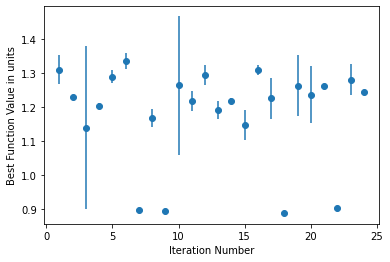

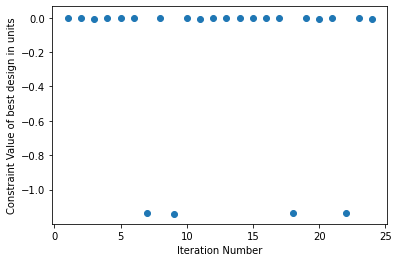

In [6]:
### TEST PROBLEM
## Don't show warnings 
warnings.filterwarnings('ignore')

nx_dim = 1
x_range = [[0, 1.2]] # in units

n_gt = 10 # number of design samples used to train the ground truth GP
n_f1 = 40 # number of design samples used to train the analytical model GP
n_f2 = 40 # number of design smaples used to train the neural network GP
n_fs = [n_f1, n_f2]

n_c_gt = 10 # number of design samples used to train the constraint ground truth GP
n_const1 = 40 # number of design smaples used to train the first lower fidelity constraint GP
n_const2 = 40 # number of design smaples used to train the second lower fidelity constraint GP
n_cs = [n_const1, n_const2]

n_test = 50 # number of design samples used to fuse GPs
n_alt = 30 # number of candidate designs to sample in each iteration

cost_gt_f = 100 # cost of evaluating a design using high fidelity model
cost_f1 = 25 # cost of evaluating a design using low fidelity model 1
cost_f2 = 20 # cost of evaluating a design using low fidelity model 2
cost_fs = [cost_gt_f, cost_f1, cost_f2]

cost_gt_c = 40 # cost of evaluating constraint for a design using ground truth 
cost_c1 = 10 # cost of evaluating constraint for a design using lower fidelity model 1
cost_c2 = 5 # cost of evaluating constraint for a design using lower fidelity model 2
cost_cs = [cost_gt_c, cost_c1, cost_c2]

max_cost = 5000 # stopping criterion in seconds
vf_lim = 0.1 # not useful here but provided as a required input to the optimization function
prob = 'test'

x_best_dict, y_best_vec, y_best_std_vec, c_best_vec, c_best_std_vec, cost_vec = MFCBO(nx_dim, x_range, n_gt, n_fs, n_c_gt, n_cs, n_alt, n_test, cost_fs, cost_cs, max_cost, vf_lim, prob)     

## Plot the Best Function Values by iteration number
n_iterations = len(y_best_vec)
x_iter = np.linspace(1, n_iterations, n_iterations)
y_cb = [3*i for i in y_best_std_vec]
fig1 = plt.figure()
plt.errorbar(x_iter, y_best_vec, yerr=y_cb, fmt='o')
plt.xlabel('Iteration Number')
plt.ylabel('Best Function Value in units')
plt.show()
fig1.savefig('ybest_vs_iter_test.png')

## Plot the Constraint Values of the best design by iteration number
fig2 = plt.figure()
c_cb = [3*i for i in c_best_std_vec]
plt.errorbar(x_iter, c_best_vec, yerr=c_cb, fmt='o')
plt.xlabel('Iteration Number')
plt.ylabel('Constraint Value of best design in units')
plt.show()
fig2.savefig('c_best_vs_iter_test.png')

In [14]:
### COMPOSITE PLATE PROBLEM
## Don't show warnings 
warnings.filterwarnings('ignore')

l = 3048 # length of composite plate in mm
w = 3048 # width of composite plate in mm
t = 254 # thickness of composite plate in mm
E_f = 121 # Young's Modulus of fibre in GPa (same as abaqus fea, this is the Young's Modulus of Copper)

nx_dim = 3
rf_range = [25, (t/2)-20] # in mm
thetaf_range = [0, 90] # in degrees
Em_range = [10, 800] # in GPa 
x_range = np.vstack((rf_range, thetaf_range, Em_range))

n_test = 150 # number of design samples used to fuse GPs
n_alt = 100 # number of candidate designs to sample in each iteration

n_gt = 10 # number of design samples used to train the ground truth GP
n_f1 = 50 # number of design samples used to train the analytical model GP
n_f2 = 50 # number of design smaples used to train the neural network GP
n_fs = [n_f1, n_f2]

n_c_gt = 10 # number of design samples used to train the ground truth constraint GP
n_const1 = 50 # number of design samples used to train the first lower fidelity constraint GP
n_const2 = 50 # number of design samples used to train the second lower fidelity constraint GP
n_cs = [n_const1, n_const2]

cost_gt_f = 2000 # cost of evaluating a design using abaqus fea model 
cost_f1 = 50 # cost of evaluating a design using analytical model 
cost_f2 = 30 # cost of evaluating a design using neural network 
cost_fs = [cost_gt_f, cost_f1, cost_f2]

cost_gt_c = 100 # cost of evaluating constraint for a design using ground truth 
cost_c1 = 20 # cost of evaluating constraint for a design using lower fidelity model 1
cost_c2 = 10 # cost of evaluating constraint for a design using lower fidelity model 2
cost_cs = [cost_gt_c, cost_c1, cost_c2]

max_cost = 40000 # stopping criterion in seconds
vf_lim = 0.75 # constraint limit
prob = 'composite_plate'

x_best_dict, y_best_vec, y_best_std_vec, c_best_vec, c_best_std_vec, cost_vec = MFCBO(nx_dim, x_range, n_gt, n_fs, n_c_gt, n_cs, n_alt, n_test, cost_fs, cost_cs, max_cost, vf_lim, prob)     

## Plot the Best Function Values by iteration number
n_iterations = len(y_best_vec)
x_iter = np.linspace(1, n_iterations, n_iterations)
y_cb = [3*i for i in y_best_std_vec]
fig1 = plt.figure()
plt.errorbar(x_iter, y_best_vec, yerr=y_cb, fmt='o')
plt.xlabel('Iteration Number')
plt.ylabel('Maximum Effective Buckling Load in N/mm^2')
plt.show()
fig1.savefig('ybest_vs_iter_compplate.png')

## Plot the Constraint Values of the best design by iteration number
fig2 = plt.figure()
c_cb = [3*i for i in c_best_std_vec]
plt.plot(x_iter, c_best_vec, yerr=c_cb, fmt='o')
plt.xlabel('Iteration Number')
plt.ylabel('Constraint Value of best design')
plt.show()
fig2.savefig('c_best_vs_iter_compplate.png')

Starting iteration 1
Initialization complete
Infeasible designs filtered


ValueError: zero-size array to reduction operation maximum which has no identity